In [10]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import load_wine
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn

In [11]:
data = load_wine(as_frame=True)
df = data.data
df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0


In [12]:
df_scaled = MinMaxScaler().fit_transform(df)
df_scaled

array([[0.84210526, 0.1916996 , 0.57219251, ..., 0.45528455, 0.97069597,
        0.56134094],
       [0.57105263, 0.2055336 , 0.4171123 , ..., 0.46341463, 0.78021978,
        0.55064194],
       [0.56052632, 0.3201581 , 0.70053476, ..., 0.44715447, 0.6959707 ,
        0.64693295],
       ...,
       [0.58947368, 0.69960474, 0.48128342, ..., 0.08943089, 0.10622711,
        0.39728959],
       [0.56315789, 0.36561265, 0.54010695, ..., 0.09756098, 0.12820513,
        0.40085592],
       [0.81578947, 0.66403162, 0.73796791, ..., 0.10569106, 0.12087912,
        0.20114123]])

In [13]:
class WineDataset(Dataset):
    def __init__(self, df):
        self.x = df

    def __getitem__(self, idx):
        x = torch.tensor(self.x[idx], dtype=torch.float)
        return x

    def __len__(self):
        return np.size(self.x, 0)

In [14]:
dataset = WineDataset(df_scaled)
dataloader = DataLoader(dataset, shuffle=True)
len(dataset)

178

In [15]:
class MixedTypeClusteringModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(13, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 7),
            torch.nn.ReLU(),
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(7, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 13),
            torch.nn.Sigmoid()
        )


    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


epochs = 10
lr = 0.001

model = MixedTypeClusteringModel()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(epochs):
    model.train()
    loss = 0

    for x in dataloader:
        optimizer.zero_grad()
        outputs = model(x)
        train_loss = criterion(outputs, x)
        train_loss.backward()
        optimizer.step()
        loss += train_loss.item()

    loss = loss / len(dataloader)
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

epoch : 1/10, loss = 0.053416
epoch : 2/10, loss = 0.043821
epoch : 3/10, loss = 0.041713
epoch : 4/10, loss = 0.040579
epoch : 5/10, loss = 0.037228
epoch : 6/10, loss = 0.032652
epoch : 7/10, loss = 0.028314
epoch : 8/10, loss = 0.025679
epoch : 9/10, loss = 0.023835
epoch : 10/10, loss = 0.022181


In [16]:
features = model.encoder(torch.tensor(df_scaled, dtype=torch.float)).detach().numpy()
features

array([[1.1327028 , 0.        , 0.70706075, ..., 0.28525823, 1.6197262 ,
        0.        ],
       [0.8669157 , 0.        , 0.6553197 , ..., 0.10996546, 1.3542757 ,
        0.        ],
       [1.0899882 , 0.        , 0.81398785, ..., 0.42930567, 1.5821041 ,
        0.        ],
       ...,
       [0.7960428 , 0.        , 1.3995496 , ..., 1.3917267 , 0.22486393,
        0.        ],
       [0.86192286, 0.        , 1.458236  , ..., 1.5051769 , 0.19316722,
        0.        ],
       [0.8187096 , 0.        , 1.6472039 , ..., 1.8046311 , 0.06806178,
        0.        ]], dtype=float32)

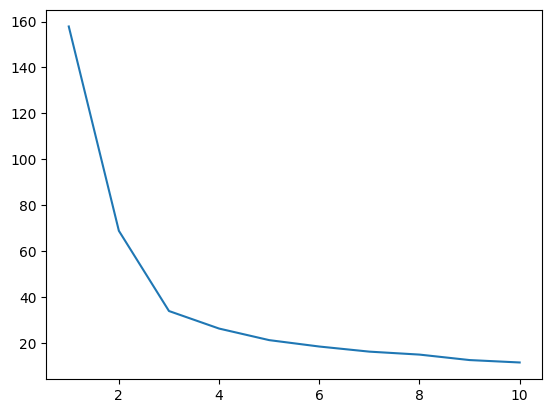

In [17]:
results = list()
k_cand = range(1, 11)

for k in k_cand:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(features)
    results.append(kmeans.inertia_)

fig, ax = plt.subplots()
ax.plot(k_cand, results)

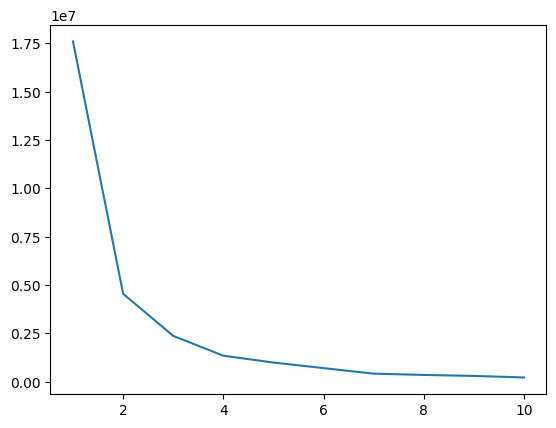

In [19]:
# Without the encoder

results = list()
k_cand = range(1, 11)

for k in k_cand:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(df)
    results.append(kmeans.inertia_)

fig, ax = plt.subplots()
ax.plot(k_cand, results)